In [1]:
import pandas as pd
from sklearn import svm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from typing import List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


train_df = pd.read_csv("train_ScotiaDSD.csv")
train_df = train_df.set_index('TRANSACTION_ID')

count_class_0, count_class_1 = train_df.FRAUD_FLAG.value_counts()
#print(count_class_0, count_class_1 )

df_class_0 = train_df[train_df['FRAUD_FLAG'] == 0]
df_class_1 = train_df[train_df['FRAUD_FLAG'] == 1]
print(len(df_class_0), len(df_class_1))

PARTITION_SIZE = 7500#2177
ensemble = []
_last_slice = 0
for i in range(len(df_class_0) // PARTITION_SIZE):
    ensemble.append(
        pd.concat([df_class_0.iloc[i*PARTITION_SIZE:(i+1)*PARTITION_SIZE, :].copy(),
                   df_class_1.copy()]))
    _last_slice = (i+1)*PARTITION_SIZE
ensemble.append(
    pd.concat([df_class_0.iloc[_last_slice:, :].copy(), df_class_1.copy()])
)
print(sum(len(e)-len(df_class_1) for e in ensemble))

87076 2154
87076


<AxesSubplot:title={'center':'Count (fraud)'}>

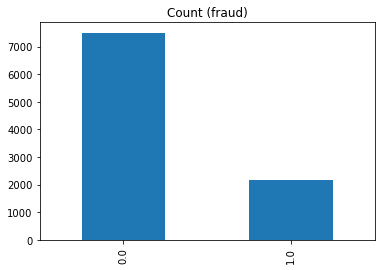

In [2]:
###### as a test
ensemble[0].FRAUD_FLAG.value_counts().plot(kind='bar', title='Count (fraud)')

In [3]:
test_df = pd.read_csv("test_ScotiaDSD.csv")
test_df = test_df.set_index('TRANSACTION_ID')

In [4]:
from sklearn.decomposition import PCA

def run_model(master_df, train_df, test_df, model, reduction):
    X_master = master_df.drop(columns=['FRAUD_FLAG'])
    X_train = train_df.drop(columns=['FRAUD_FLAG'])
    X_test = test_df.drop(columns=['FRAUD_FLAG'])
    train_len = len(X_train)
    test_len = len(X_test)
    
    y_master = master_df.FRAUD_FLAG
    y_train = train_df.FRAUD_FLAG
    
    enc = OneHotEncoder() #LabelEncoder()
    X = pd.concat([X_train, X_test, X_master])
    X.CITY = X.CITY.astype('category')
    X.USER_AGENT = X.USER_AGENT.astype('category')
    
    X = pd.concat([X, pd.DataFrame(data=enc.fit_transform(X[["CITY"]]).toarray(), index=X.index)], axis=1)
    X = pd.concat([X, pd.DataFrame(data=enc.fit_transform(X[["USER_AGENT"]]).toarray(), index=X.index)], axis=1)

    X = X.drop(columns=['USER_AGENT', 'CITY'])
    #print(X['CITY_ENC'].head(5))

    # assumes events do not start with :
    def convertEventToMinutes(events: List[str]) -> List[int]:
        minutes = []
        for time in events:
            index = 0
            hour = -1 # number before first :
            minute = -1 # number after first :
            minuteStartIndex = -1 # index where minute starts
            while index < len(time):
                if time[index] == ':':
                    if hour == -1: # first time we hit :
                        hour = int(time[0:index])
                    elif minute == -1:
                        minute = int(time[minuteStartIndex:index])
                elif hour != -1 and minuteStartIndex == -1:
                    minuteStartIndex = index
                index += 1
            if minute == -1:
                minute = int(time[minuteStartIndex:index])
            minutes.append(hour * 60 + minute)
        return minutes

    X['EVENT_TIME_MIN'] = convertEventToMinutes(X['EVENT_TIME'])
    X = X.drop(columns=['EVENT_TIME'])

    X_train = X.iloc[:train_len, :].copy()
    X_test = X.iloc[train_len:train_len+test_len, :].copy()
    X_master = X.iloc[train_len+test_len:, :].copy()

    scaler = StandardScaler()
    pca = PCA(n_components=reduction)
    X_train = scaler.fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    

    scores = cross_val_score(model, X_train, y_train, cv=8, scoring="accuracy", n_jobs=-1)
    model = model.fit(X_train, y_train)

    def pipeline(_X):
        return pca.transform(scaler.transform(_X))
    print("train_accuracy", accuracy_score(y_master.values,
                        model.predict(pipeline(X_master))), f" || cross_validation: {scores.mean()}+/-{scores.std()}")
    return model.predict(pipeline(X_test)), model.predict(pipeline(X_master))

# logistic regression
results = []
for i,e in enumerate(ensemble):
    print(f"Trial {i} || ", end="")
    y_pred, y_pred_master = run_model(train_df, e, test_df,
                                      LogisticRegression(C=0.1, tol=1e-5, solver='liblinear'),
                                      reduction=16)
    test_df["FRAUD_FLAG"] = y_pred
    test_out = test_df[["FRAUD_FLAG",]]
    test_out.to_csv(f"ensemble_logistic_{i}.csv")
    if i>0:
        results.append(y_pred_master)

# SVM
# for i,e in enumerate(ensemble):
#     print(f"Trial {i} || ", end="")
#     y_pred, y_pred_master = run_model(train_df, e, test_df,
#                                       svm.LinearSVC(C=0.01, tol=1e-5, random_state=0, dual=False),
#                                       reduction=16)
#     test_df["FRAUD_FLAG"] = y_pred
#     test_out = test_df[["FRAUD_FLAG",]]
#     test_out.to_csv(f"ensemble_svm_{i}.csv")
#     results += y_pred_master

# for i,e in enumerate(ensemble):
#     print(f"Trial {i} || ", end="")
#     y_pred, y_pred_master = run_model(train_df, e, test_df, SGDClassifier(random_state=0))
#     test_df["FRAUD_FLAG"] = y_pred
#     test_out = test_df[["FRAUD_FLAG",]]
#     test_out.to_csv(f"ensemble_logistic_{i}.csv")
#     results += y_pred_master







Trial 0 || train_accuracy 0.6090440434831335  || cross_validation: 0.94189677132152+/-0.04677454176208357
Trial 1 || train_accuracy 0.7138966715230304  || cross_validation: 0.9289487044204551+/-0.050810627633933056
Trial 2 || train_accuracy 0.6968508349209906  || cross_validation: 0.9274998591686692+/-0.05411464626845432
Trial 3 || train_accuracy 0.8635548582315364  || cross_validation: 0.904606867622671+/-0.044825640075728826
Trial 4 || train_accuracy 0.853502185363667  || cross_validation: 0.9104097195601666+/-0.038363825582405406
Trial 5 || train_accuracy 0.9227389891292166  || cross_validation: 0.8713499782226675+/-0.016139598547852716
Trial 6 || train_accuracy 0.6751765101423288  || cross_validation: 0.9433396913526815+/-0.037452095866096616
Trial 7 || train_accuracy 0.8094138742575367  || cross_validation: 0.9252081727512671+/-0.03822524650088955
Trial 8 || train_accuracy 0.8688221450184915  || cross_validation: 0.8990994179887637+/-0.04241548789329492
Trial 9 || train_accuracy 0

In [5]:
filtered = results[:-1]
pred = 0.0
for i in range(len(filtered)):
    pred += filtered[i]

pred = pred / 8
pred

array([0.   , 0.625, 0.75 , ..., 0.25 , 0.   , 0.   ])

In [8]:
pred = pred >= 0.9
print(pred)
y_master = train_df.FRAUD_FLAG
accuracy_score(y_master.values, pred)

[False False False ... False False False]


0.9305278493780119

Confusion matrix:
 [[81723  5353]
 [  846  1308]]


C:\Users\thoma\AppData\Local\Temp/ipykernel_9872/2231358599.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\thoma\AppData\Local\Temp/ipykernel_9872/2231358599.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


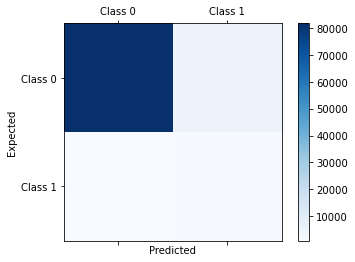

In [7]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_master, y_pred=pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()